### Playing around with hard disk failure data

(source: Kaggle https://www.kaggle.com/ezeydan/hard-drive-failure-data)

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                                 GeneralizedAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SaliencybasedGeneralizedAnomalyScoreV2, 
                 FFTbasedGeneralizedAnomalyScoreV2, KMeansAnomalyScoreV2, MatrixProfileAnomalyScore)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import networkx as nx

from pandas.plotting import register_matplotlib_converters
import seaborn as sns

from reliability.Distributions import (Weibull_Distribution,Competing_Risks_Model)
from reliability.Fitters import (Fit_Weibull_2P, Fit_Weibull_3P, Fit_Everything, Fit_Weibull_CR, 
        Fit_Weibull_Mixture)
from reliability.Probability_plotting import (Normal_probability_plot, Weibull_probability_plot, 
        Exponential_probability_plot, QQ_plot_parametric, QQ_plot_semiparametric)
from reliability.Nonparametric import KaplanMeier

register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
#fd = pd.read_csv('./data/machine_failure_data.csv')
fd = pd.read_csv('./data/hard_drive_failure_data.csv')


### Exploratory analysis

In [3]:
# check of right censored data

fd[fd['failure'] != 1]

2022-03-10T10:51:20.810 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-03-10T10:51:20.811 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


,@timestamp,@version,capacity_bytes,date,failure,model,serial_number,lifetime


#### No right-censored data !

In [4]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

describe(fd[['lifetime']], ['skew', 'mad', 'kurt'])

,lifetime
count,2987
mean,308.559
std,210.715
min,0
25%,119
50%,290
75%,480
max,730
skew,0.245452
mad,183.523


In [5]:
#fd_pos = fd[fd['lifetime']>0]
#describe(fd_pos[['lifetime']], ['skew', 'mad', 'kurt'])

In [6]:
lifetimes_all = fd['lifetime'].values
lifetimes_all.sort()
#plt.scatter(range(len(lifetimes_all)), lifetimes_all)

<AxesSubplot:ylabel='Count'>

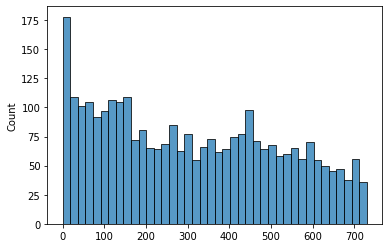

In [7]:
sns.histplot(data=lifetimes_all, bins=40)

In [8]:
lifetimes_all_pos = lifetimes_all[lifetimes_all > 0]
lifetimes_trans = lifetimes_all ** 1.4
print(lifetimes_all.shape, lifetimes_trans.shape)

(2987,) (2987,)


<AxesSubplot:ylabel='Count'>

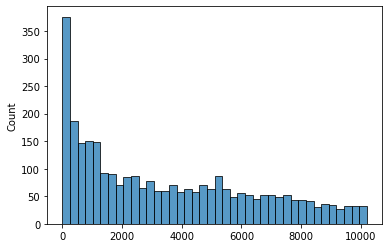

In [9]:
sns.histplot(data=lifetimes_trans, bins=40)

Results from Fit_Weibull_CR (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2964/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
  Alpha 1         422.135         13.3966   396.678   449.225
   Beta 1        0.969656       0.0245254   0.92276   1.01894
  Alpha 2          619.69         6.77655    606.55   633.115
   Beta 2          6.7306        0.431082   5.93658   7.63083 

Goodness of fit    Value
 Log-likelihood -19480.4
           AICc  38968.8
            BIC  38992.7
             AD  1.88113 



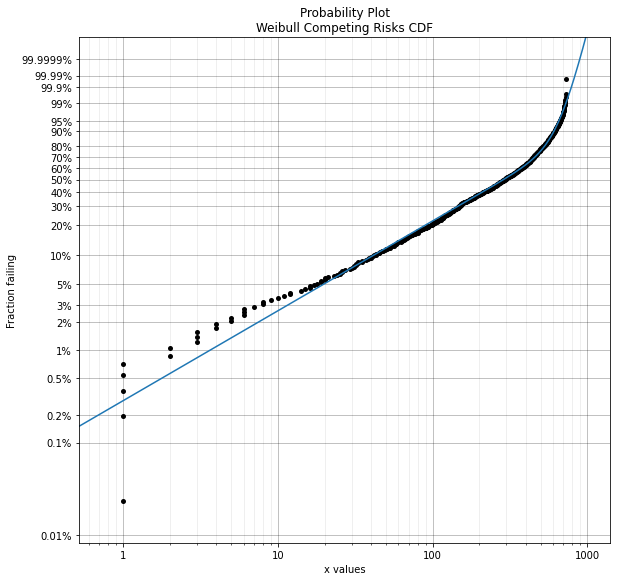

In [10]:
fit = fit_all = Fit_Weibull_CR(failures=lifetimes_all_pos) #, show_probability_plot=False)

#### Regardless of how we transform we have too many modes here

so we might end up with additive or product based mixture model

#### try all relevant distributions

This takes running scipy's optimizer a couple of time to minimize the log likelihood of data (incl right censored data which is absent here).

The code makes us of typical information criteria metrics and employs Anderson-Darling as built-in goodness of fit test.

In [11]:
#fit_all = Fit_Everything(failures=lifetimes_all_pos, show_probability_plot=False)

### Focus on a single class 

In [12]:
# focus on larger disks first
lifetimes_4 = fd[fd['capacity_bytes'] == 4000787030016.0]['lifetime'].values
lifetimes_8 = fd[fd['capacity_bytes'] >= 8001563222016.0]['lifetime'].values
lifetimes_4 = lifetimes_4[lifetimes_4 > 0]
lifetimes_8 = lifetimes_8[lifetimes_8 > 0]


### Exploratory analysis

In [13]:
sp.stats.describe(lifetimes_4)

DescribeResult(nobs=2290, minmax=(1, 730), mean=308.8812227074236, variance=43844.48916233133, skewness=0.22913088799696096, kurtosis=-1.1539144627482705)

<AxesSubplot:ylabel='Count'>

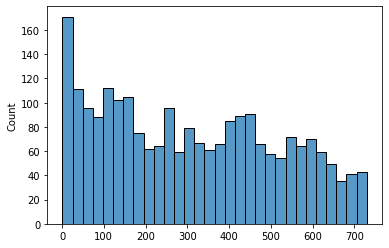

In [14]:
sns.histplot(data=lifetimes_4, bins=30)

#### Again we have an extra mode around 425

Let's see whether we can simply split head and tail following 
https://arxiv.org/ftp/arxiv/papers/1209/1209.2801.pdf

This is a light-tailed distribution so we split the tail instead of the head


In [15]:
head_tail_split = 0.4
def head_tail_break(data, results=None):
    if results is None:
        results = []
    mu = np.mean(data)
    head = data[data > mu]
    tail = data[data < mu]
    results.append(mu)

    while len(head) > 1 and len(head) / len(data) < head_tail_split: return head_tail_break(head, results)
    return results
    

In [16]:
htb = head_tail_break(lifetimes_all)

In [17]:
htb

[308.5587546032809]

<AxesSubplot:ylabel='Count'>

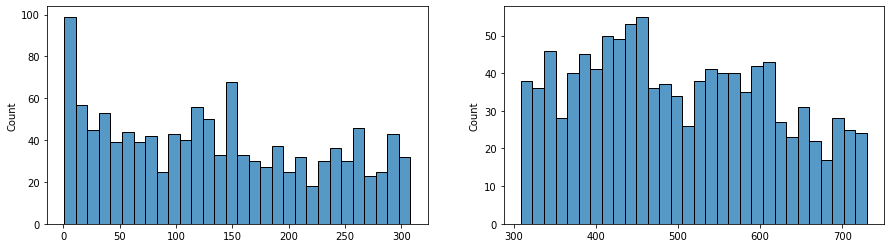

In [18]:
fig,ax = plt.subplots(1,2, figsize=(15,4))
sns.histplot(data=lifetimes_4[lifetimes_4<htb[0]], bins=30, ax=ax[0])
sns.histplot(data=lifetimes_4[lifetimes_4>=htb[0]], bins=30, ax=ax[1])

#### Doesn't look much better

### Digression: Trying to understand how to fit a Weibull CR model

First, separate data into two group and fit a Weibull to each group

730 1
42.67862407862407 0.00024350555781415227


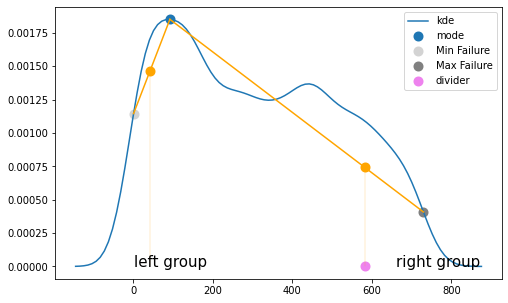

In [19]:
# finding the split point
#   I haven't found a reference for this method

max_failures = max(lifetimes_all_pos)
min_failures = min(lifetimes_all_pos)
print(max_failures, min_failures)

gkde = sp.stats.gaussian_kde(lifetimes_all_pos)
delta = max_failures - min_failures
x_kde = np.linspace(min_failures - delta / 5, max_failures + delta / 5, 100)
y_kde = gkde.evaluate(x_kde)
peak_y = max(y_kde)
peak_x = x_kde[np.where(y_kde == peak_y)][0]


left_x = min_failures
left_y = gkde.evaluate(left_x)
left_m = (peak_y - left_y) / (peak_x - left_x)
left_c = -left_m * left_x + left_y
left_line_x = np.linspace(left_x, peak_x, 1000)
left_line_y = left_m * left_line_x + left_c  # y=mx+c
left_kde = gkde.evaluate(left_line_x)
left_diff = abs(left_line_y - left_kde)
left_diff_max = max(left_diff)
left_div_line = left_line_x[np.where(left_diff == left_diff_max)][0]
print(left_div_line, left_diff_max)

right_x = max_failures
right_y = gkde.evaluate(right_x)
right_m = (right_y - peak_y) / (right_x - peak_x)
right_c = -right_m * right_x + right_y
right_line_x = np.linspace(peak_x, right_x, 1000)
right_line_y = right_m * right_line_x + right_c  # y=mx+c
right_kde = gkde.evaluate(right_line_x)
right_diff = abs(right_line_y - right_kde)
right_diff_max = max(right_diff)
right_div_line = right_line_x[np.where(right_diff == right_diff_max)][0]

if left_diff_max > right_diff_max:
    dividing_line = left_div_line
else:
    dividing_line = right_div_line

#print(dividing_line, left_diff_max, right_diff_max)

max_left_point = left_line_y[np.where(left_diff == left_diff_max)][0]
max_right_point = right_line_y[np.where(right_diff == right_diff_max)][0]

plt.figure(figsize=(8, 5))

plt.plot(x_kde, y_kde, label='kde')
plt.scatter(peak_x, peak_y, lw=4, label='mode')
plt.plot(left_line_x, left_line_y, c='orange')
plt.scatter(left_x, left_y, lw=4, c='lightgrey', label='Min Failure')
plt.scatter(left_div_line, max_left_point, lw=4, c='orange')
plt.plot(right_line_x, right_line_y, c='orange')
plt.scatter(right_x, right_y, lw=4, c='grey', label='Max Failure')
plt.scatter(right_div_line, max_right_point, lw=4, c='orange')
plt.plot((left_div_line,left_div_line), (0, max_left_point), lw=0.4, alpha=0.5, c='orange')
plt.plot((right_div_line,right_div_line), (0, max_right_point), lw=0.4, alpha=0.5, c='orange')
plt.scatter(dividing_line, 0, lw=4, c='violet', label='divider')
plt.annotate('left group', xy=(min_failures, 0), fontsize=15)
plt.annotate('right group', xy=(dividing_line + 80, 0), fontsize=15)
#plt.hist(lifetimes, bins=30, alpha=0.1)


plt.legend()


In [20]:
#lifetimes_all_pos.sort()
group1 = lifetimes_all_pos[lifetimes_all_pos < dividing_line]
group2 = lifetimes_all_pos[lifetimes_all_pos >= dividing_line]
#group1 = lifetimes[lifetimes < 100]
#group2 = lifetimes[lifetimes >= 100]
fit1 = Fit_Weibull_2P(failures=group1, show_probability_plot=False)
fit2 = Fit_Weibull_2P(failures=group2, show_probability_plot=False)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2562/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         276.435         4.35669   268.027   285.107
     Beta         1.30717       0.0218998   1.26495   1.35081 

Goodness of fit    Value
 Log-likelihood -16671.4
           AICc  33346.9
            BIC  33358.6
             AD  42.9826 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 402/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         670.631         2.17275   666.386   674.903
     Beta         16.3098        0.628558   15.1232   17.5895 

Goodness of fit    Value
 Log-likelihood -2102.46
           AICc  4208.95
            BIC  4216.92
             AD  7.45241 



#### Log likelihood of Weibull CR w/o censored data

With Matthew Reid's help I could derive the log likelihood for Weibull CR.

According to "Ishioka, T.; Nonaka, Y. (1991). Maximum likelihood estimation of Weibull parameters for two independent competing risk. , 40(1), 71–74." we have

$$
    SF: R_{CR} = R_1 x R_2  \hspace{.3in} where \hspace{.3in} R_{i} = exp \left( \frac{t}{\alpha_{i}} \right)^{\beta_i}
$$

$$
    CDF: F_{CR} = 1 - R_{CR}
$$

$$
    HF: h_{CR} = h_1 + h_2 \hspace{.3in} where \hspace{.3in} h_i = \frac{\beta_i}{\alpha_i}
    \left(\frac{t}{\alpha_i}\right)^{\beta_i - 1}
$$

$$
    PDF: f_{CR} = h_{CR} x R_{CR} = \left[
       \frac{\beta_1}{\alpha_1} \left(\frac{t}{\alpha_1}\right)^{\beta_1 - 1} +
       \frac{\beta_2}{\alpha_1} \left(\frac{t}{\alpha_2}\right)^{\beta_2 - 1}
    \right] exp \left[ \left( \frac{t}{\alpha_{1}} \right)^{\beta_1} + 
    \left( \frac{t}{\alpha_{2}} \right)^{\beta_2} \right]
$$
.

With f for failure and rc for right-censored data we get


$$
    L(\theta|.) = \prod_{i=n}^{n} f_{CR}(t_i^{f} | \theta) \hspace{.1in} x
      \hspace{.1in} R_{CR}(t_i^{rc} | \theta)
$$


The right-censored data set is empty so taking the log yields

$$
log( L(\theta|.)) = \sum_{i} log \left( \left[ \frac{\beta_2}{t_i} \left( \frac{t_i}{\alpha_2} \right)^{\beta_2} + 
\frac{\beta_1}{t_i} \left( \frac{t_i}{\alpha_1} \right)^{\beta_1} \right]
exp \left[ -\left(\frac{t}{\alpha_2}\right)^{\beta_2} - 
\left(\frac{t}{\alpha_1}\right)^{\beta_1} \right] \right)
  \hspace{.3in},
\theta = (\alpha_1,\alpha_2,\beta_1,\beta_2)
$$ 

#### .

In [21]:
import autograd.numpy as anp
from autograd import value_and_grad
from autograd.differential_operators import hessian
from autograd.scipy.special import gamma as agamma
from autograd.scipy.special import beta as abeta
from autograd.scipy.special import erf

from reliability.Utils import (MLE_optimization)


def logf(t, a1, b1, a2, b2):  # Log PDF for failure data
    return anp.log(
        -(-(b2 * (t / a2) ** b2) / t - (b1 * (t / a1) ** b1) / t)
        * anp.exp(-((t / a2) ** b2) - (t / a1) ** b1)
    )

def logR(t, a1, b1, a2, b2):  # Log SF (Competing Risks)
    return -((t / a1) ** b1) - ((t / a2) ** b2)

def LL(params, T_f, T_rc):
    # Log Likelihood for failure data
    LL_f = logf(
        T_f, params[0], params[1], params[2], params[3]
    ).sum()
    # Log Likelihood survival function for right censored data
    LL_rc = logR(
        T_rc, params[0], params[1], params[2], params[3]
    ).sum()
    return -(LL_f + LL_rc)


In [22]:
MLE_results = MLE_optimization(
            func_name="Weibull_CR",
            LL_func=LL,
            initial_guess= [fit1.alpha, fit1.beta, fit2.alpha, fit2.beta],
            failures=lifetimes_all_pos,
            right_censored=[],
            optimizer="L-BFGS-B"
        )

In [23]:
alpha_1 = MLE_results.alpha_1
beta_1 = MLE_results.beta_1
alpha_2 = MLE_results.alpha_2
beta_2 = MLE_results.beta_2
dist_1 = Weibull_Distribution(alpha=alpha_1, beta=beta_1)
dist_2 = Weibull_Distribution(alpha=alpha_2, beta=beta_2)
full_dist = Competing_Risks_Model(distributions=[dist_1, dist_2])
alpha_1, beta_1, alpha_2, beta_2

(422.13638985852606, 0.9696543464430095, 619.688696131617, 6.7306079241376136)

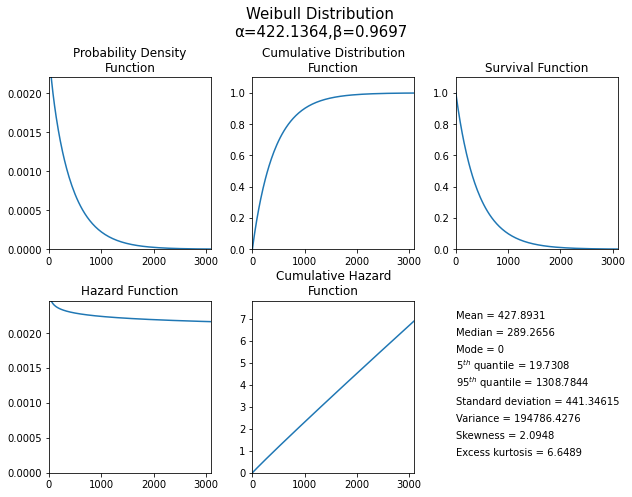

In [24]:
dist_1.plot()

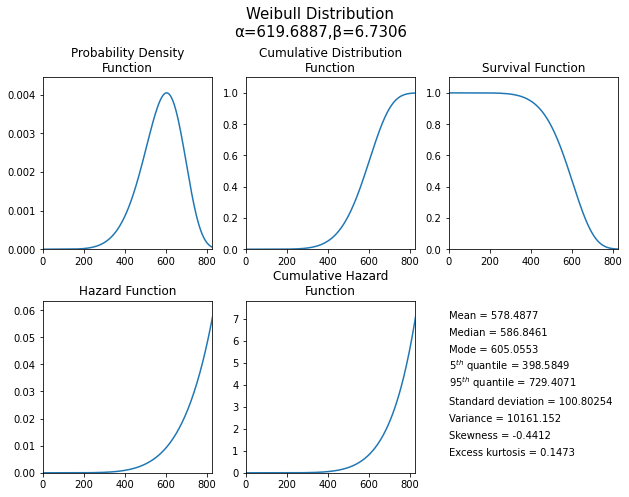

In [25]:
dist_2.plot()

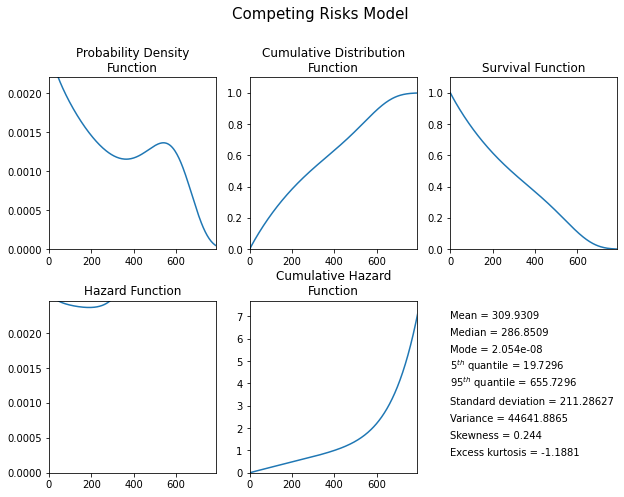

In [114]:
full_dist.plot()

[1.4225565725311327, 0.46134397074389444, 434.8602266134572]

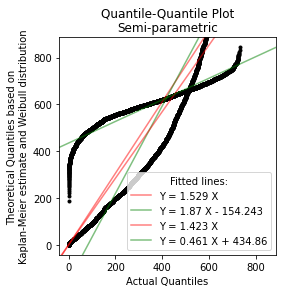

In [115]:
QQ_plot_semiparametric(X_data_failures=lifetimes_all_pos, Y_dist=dist_1) 
QQ_plot_semiparametric(X_data_failures=lifetimes_all_pos, Y_dist=dist_2)

Results from Fit_Weibull_Mixture (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2964/0 (0% right censored) 

   Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
     Alpha 1          178.39         8.63854   162.238   196.151
      Beta 1         1.12984       0.0262149   1.07961    1.1824
     Alpha 2         537.914         6.98509   524.396    551.78
      Beta 2         4.17644        0.199019   3.80403   4.58531
Proportion 1        0.558837       0.0222671  0.514851  0.601919 

Goodness of fit    Value
 Log-likelihood -19522.6
           AICc  39055.2
            BIC  39085.2
             AD  3.63784 



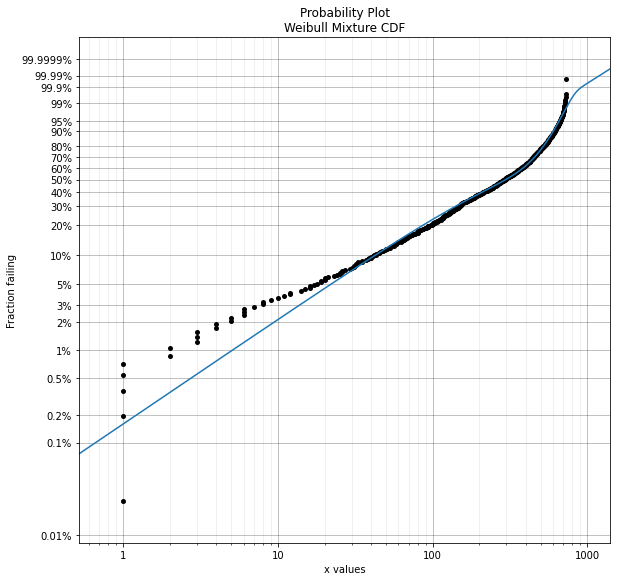

In [120]:
fit = Fit_Weibull_Mixture(
                    failures=lifetimes_all_pos,
                    right_censored=None,
                    #show_probability_plot=False,
                    #print_results=False,
                    )
plt.show()

### Non parametric models

In [ ]:
lifetimes_model = fd[fd['model'] == 'ST4000DM000']['lifetime']

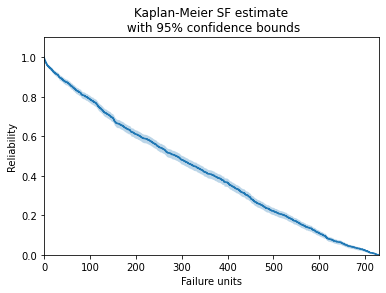

In [142]:
km = KaplanMeier(failures=lifetimes_model, label='Failures only', print_results=False, plot_CI=True)

In [154]:
km_pdf = np.diff(km.CDF)
km.results

,Failure times,Censoring code (censored=0),Items remaining,Kaplan-Meier Estimate,Lower CI bound,Upper CI bound
0,0,1,2004,0.999501,0.998523,1
1,0,1,2003,0.999002,0.99762,1
2,0,1,2002,0.998503,0.99681,1
3,0,1,2001,0.998004,0.99605,0.999958
4,0,1,2000,0.997505,0.995321,0.999689
...,...,...,...,...,...,...
1999,724,1,5,0.00199601,4.19092e-05,0.00395011
2000,725,1,4,0.00149701,0,0.00318973
2001,725,1,3,0.000998004,0,0.00238045
2002,727,1,2,0.000499002,0,0.00147678
